In [1]:
# 온라인 광고 클릭 예측을 위한 데이터 준비

In [3]:
import pandas as pd
import numpy as np

In [4]:
train_df = pd.read_csv('D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/train.csv', nrows=100000)
unused_columns, label_column = ['id', 'hour', 'device_id', 'device_ip'], 'click'
# 미사용 컬럼, 레이블 컬럼 구분
train_df = train_df.drop(unused_columns, axis=1)
# 미사용 컬럼 삭제
X_dict_train = list(train_df.drop(label_column, axis=1).T.to_dict().values())
# 특징행렬 만들기, label을 없애고, df를 전치해 딕셔너리로 만들어 valeus만 추출
y_train = train_df[label_column]

In [5]:
test_df = pd.read_csv('D:/Workspace/연습폴더/실습데이터_파이썬 머신러닝/train.csv', 
                        header=0, skiprows=(1,100000), nrows=100000)
                        #헤더 첫번째 라인, 스킵 1부터 10만까지 train이므로 스킵하고 10만개를 가져옴

test_df = test_df.drop(unused_columns, axis=1)
# 미사용 컬럼 삭제
X_dict_test = list(test_df.drop(label_column, axis=1).T.to_dict().values())
y_test = test_df[label_column]

In [8]:
# 원 핫 인코딩 벡터 변환
from sklearn.feature_extraction import DictVectorizer
# 수치형은 트리기반 모델 가능하지만
# 범주형 데이터는 변환이 필요함
vectorize = DictVectorizer(sparse=True) #sparse=True 희소행렬로 만들어줌, 안하면 컴퓨터 꺼질수 있음(메모리에 문제)
X_train = vectorize.fit_transform(X_dict_train)
X_test = vectorize.transform(X_dict_test)


In [10]:
# 그리드 서치를 이용한 로지스틱 회귀 모델학습
# LogisticRegresiion은 이진분류기, 대규모 데이터를 다룰 때 매우 유용

In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
# 매개변수 C= C의 값이 커지면 규제가 느슨해짐(오버피팅), 0에 가까워 지면 규제가 강해짐
# penalty= l1(패널티 0이 됨), l2(패널티 0에 가까워 짐) 규제가 있음 오버피팅 방지를 위함.
clf.fit(X_train, y_train)

LogisticRegression()

In [35]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ["l1", "l2"]}
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.6358266         nan 0.6390418         nan 0.63370653
        nan 0.63778526        nan 0.63773112]
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [47]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [48]:
# 로지스틱 회귀모델의 성능 측정 : 정ghkr도, 혼동행렬, ROC의 AUC

In [49]:
clf_best = grid_search.estimator
# 예측기를 받기

In [50]:
y_pred = clf_best.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
np.unique(y_pred, return_counts=True)
# 음성 예측, 양성 예측 

(array([0, 1], dtype=int64), array([98494,  1506], dtype=int64))

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
# 정확도 측정, 실측값(y_test), 예측값(y_pred) 순으로 작성

0.82372

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[81688,   822],
       [16806,   684]], dtype=int64)

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = clf_best.predict_proba(X_test)[:, 1]
y_pred_proba
# 로지스틱 회귀는 확률 기반이므로 predit이아닌 predict_proba 사용

array([0.15272233, 0.1527198 , 0.15269777, ..., 0.18102594, 0.1792849 ,
       0.10459085])

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

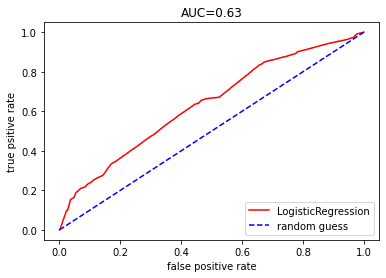

In [45]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, "r-", label='LogisticRegression')
        #x, y, color, 범례
plt.plot([0,1], [0,1], "b--", label='random guess')
        #x, y 의 점선
plt.xlabel("false positive rate")
plt.ylabel("true psitive rate")
plt.title("AUC={0:.2f}".format(auc))
plt.legend(loc='lower right');

In [32]:
# 분류기로서의 성능을 auc지표로 설명 가능